# Import statements

In [ ]:
!pip install wfdb
!pip install spkit
!pip install neurokit2
!pip install tf_keras_vis
# !pip install pydot
# !pip install graphviz

In [4]:
#preprocess
import wfdb
import matplotlib.pyplot as plt
import spkit as sp
import neurokit2 as nk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import pandas as pd

# Model
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import plot_model
# import pydot
# import graphviz

#saliency maps
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
import scipy.ndimage
from tf_keras_vis.utils.model_modifiers import GuidedBackpropagation
import scipy.ndimage

# Activation Maximization
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.regularizers import Norm, Regularizer
from tf_keras_vis.activation_maximization.input_modifiers import Jitter

/opt/conda/lib/python3.11/site-packages/tf_keras_vis/gradcam.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/gradcam_plus_plus.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/scorecam.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/utils/regularizers.py:8: DeprecationWarning: `tf_keras_vis.utils.regularizers` module is deprecated. Please use `tf_keras_vis.activation_maximization.regularizers` instead.


# Preprocess (No need to run)

### Load data

In [5]:
# get the data 
record_names = wfdb.get_record_list('mitdb')
database = 'mitdb'

#store signals from different records
signals = []

for i, rec in enumerate(record_names):
    #load record
    record = wfdb.rdrecord(f"{int(rec):02}", pn_dir = database)
    if record.fs != 360:
        print(f"Record {int(rec):02} does not have 360 fs")
        continue
    
    #load signal
    sig = record.p_signal[:,0]

    print(f"Record being collected is record number: {int(rec):02}")
    #store signals and annotations
    signals.append(sig)

Record being collected is record number: 100
Record being collected is record number: 101
Record being collected is record number: 102
Record being collected is record number: 103
Record being collected is record number: 104
Record being collected is record number: 105
Record being collected is record number: 106
Record being collected is record number: 107
Record being collected is record number: 108
Record being collected is record number: 109
Record being collected is record number: 111
Record being collected is record number: 112
Record being collected is record number: 113
Record being collected is record number: 114
Record being collected is record number: 115
Record being collected is record number: 116
Record being collected is record number: 117
Record being collected is record number: 118
Record being collected is record number: 119
Record being collected is record number: 121
Record being collected is record number: 122
Record being collected is record number: 123
Record bei

In [6]:
len(signals)

48

### Plot signals

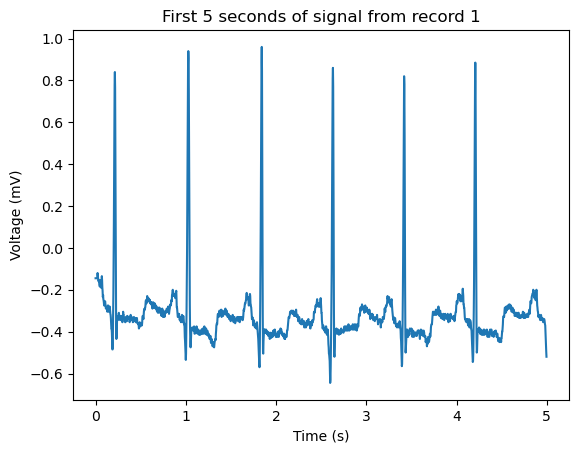

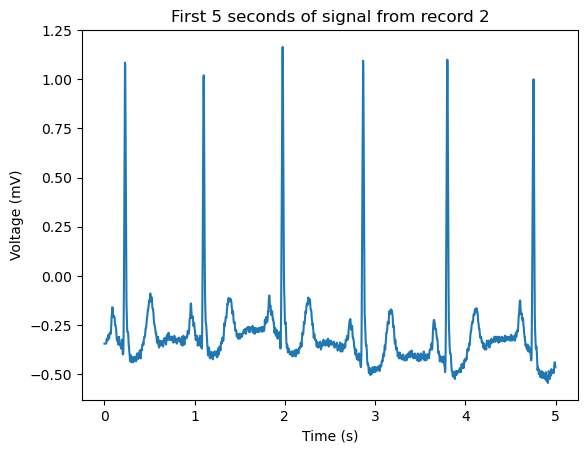

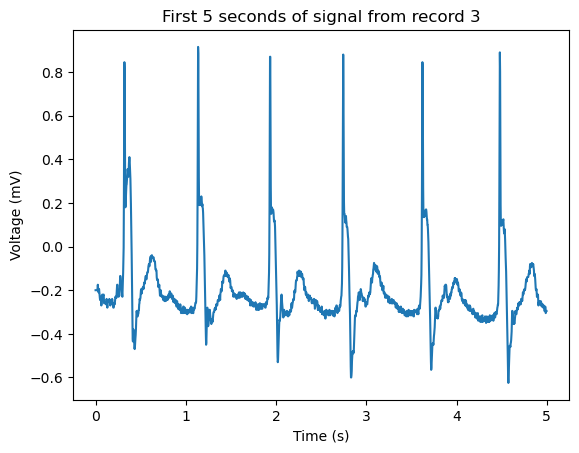

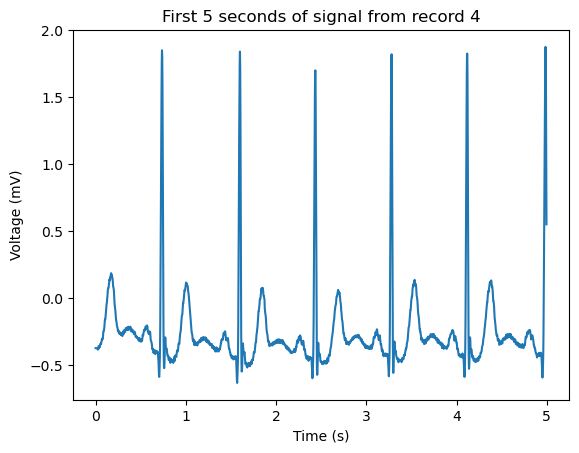

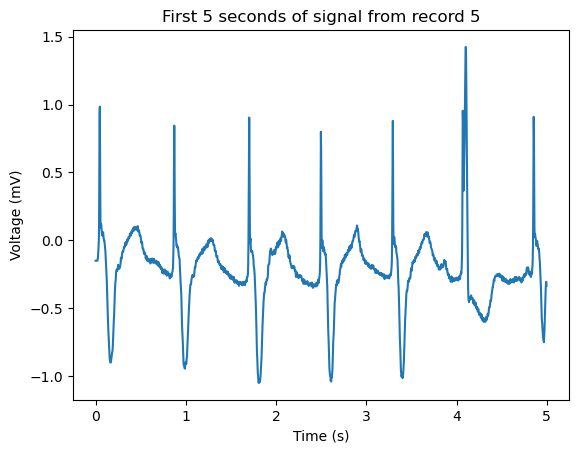

In [10]:
#plot signal and P peaks
for i in range(5):
    sig_plot = signals[i][:360 * 5]
    t = np.arange(len(sig_plot)) / 360
    
    plt.plot(t, sig_plot)
    plt.title(f'First 5 seconds of signal from record {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.show()

### Clean signals

/opt/conda/lib/python3.11/site-packages/scipy/signal/_filter_design.py:2914: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


NameError: name 'p_anns' is not defined

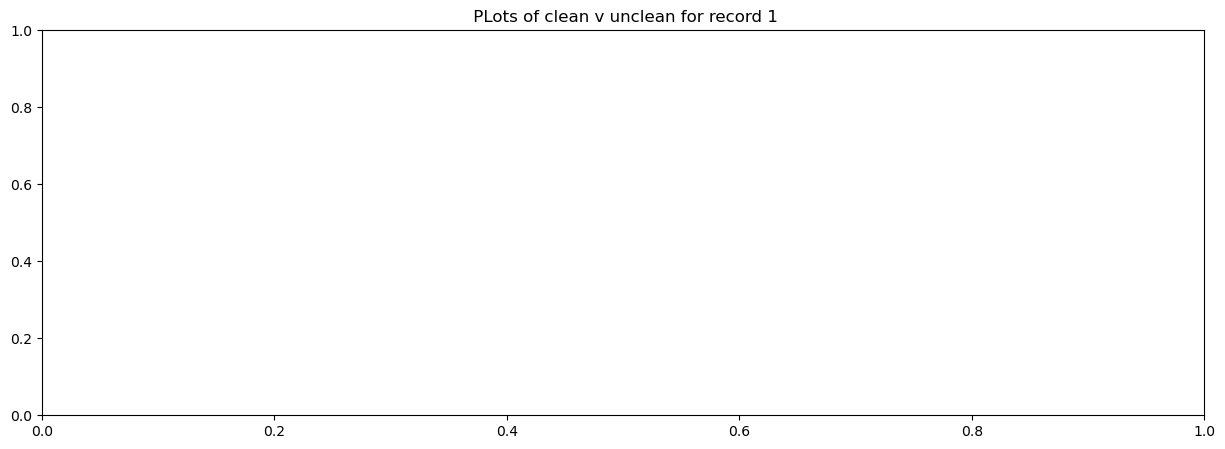

In [4]:
# clean the signals
def cleanTheSignals(signals):
    clean_signals = []
    
    for i in range(len(signals)):
        sig_clean = signals[i].copy()
        sig_clean = sp.filter_X(sig_clean,360,band=[0.5], btype='highpass',ftype='SOS')
        sig_clean = sp.filter_X(sig_clean,360,band=[150], btype='lowpass',ftype='SOS')
    
        clean_signals.append(sig_clean)

    return clean_signals

clean_signals = cleanTheSignals(signals)

for i in range(5):
    #plot signals against each other
    plt.figure(figsize = (15,5))
    plt.title(f' PLots of clean v unclean for record {i+1}')
    
    plt.plot(signals[i][:p_anns[i].sample[5]], label = 'unclean')
    plt.plot(clean_signals[i][:p_anns[i].sample[5]], label = 'clean')
    
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.plot(p_anns[i].sample[:5],clean_signals[i][p_anns[i].sample[:5]],'*')
    
    plt.legend()

### Algorithm to find peaks

In [ ]:
def FindP_peaks(signals, fs):
    p_anns =[]
    r_anns= []
    
    for i in range(len(signals)):
        _, rpeaks = nk.ecg_peaks(signals[i], sampling_rate=fs)
        rpks = rpeaks['ECG_R_Peaks']
        
        # Delineate the ECG signal
        _, waves_peak = nk.ecg_delineate(signals[i], rpks, sampling_rate=fs, method="peak")
        
        pws = waves_peak['ECG_P_Peaks']
    
        p_anns.append(pws)
        r_anns.append(rpks)
        print(f"Signal {record_names[i]} is completed")

    return p_anns, r_anns

p_anns, r_anns = FindP_peaks(clean_signals, 360)

Signal 100 is completed
Signal 101 is completed
Signal 102 is completed
Signal 103 is completed
Signal 104 is completed
Signal 105 is completed
Signal 106 is completed
Signal 107 is completed
Signal 108 is completed
Signal 109 is completed
Signal 111 is completed
Signal 112 is completed
Signal 113 is completed
Signal 114 is completed
Signal 115 is completed
Signal 116 is completed
Signal 117 is completed
Signal 118 is completed
Signal 119 is completed
Signal 121 is completed
Signal 122 is completed
Signal 123 is completed
Signal 124 is completed
Signal 200 is completed
Signal 201 is completed
Signal 202 is completed
Signal 203 is completed
Signal 205 is completed
Signal 207 is completed
Signal 208 is completed
Signal 209 is completed
Signal 210 is completed
Signal 212 is completed
Signal 213 is completed
Signal 214 is completed
Signal 215 is completed


### split into beats

In [ ]:
# split into beats
def SplitBeats(p_anns, r_anns, signals):
    #remove all nans
    for i in range(len(p_anns)):
        arr = np.array(p_anns[i])
        cleaned_arr = arr[~np.isnan(arr)] 
        p_anns[i] = cleaned_arr.astype(int).tolist()
        
    beats = []
    p_pks = []
    r_pks = []
    
    for i in range(len(signals)):
        rpks = np.array(r_anns[i], dtype=int)
        ppks = np.array(p_anns[i], dtype=int)
    
        
        #create split lines
        boundaries = np.zeros(len(rpks) + 1, dtype=int)
        for k in range(1, len(rpks)):
            boundaries[k] = (rpks[k - 1] + rpks[k]) // 2
    
        if (p for p in ppks if boundaries[j] <= p < boundaries[j+1]) in [np.nan]:
            print(f' tru and p is {p}')
    
    
       # split the beats and re align p and r peak
        for j in range(len(rpks)):
            beat = signals[i][boundaries[j]: boundaries[j+1]]
            beat = beat - np.mean(beat)
    
            #if there are no p peaks skip
            if len([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]]) == 0:
                continue
                
            beats.append(beat)
            r_pks.append(rpks[j] - boundaries[j])
            p_pks.append([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]])
        print(f"Signal {record_names[i]} is completed")

    return beats, p_pks, r_pks

beats, p_pks, r_pks = SplitBeats(p_anns, r_anns, clean_signals)

### Remove beats

In [ ]:
#how many beats before removing
len(beats)

#### length of beats

In [ ]:
#delete beats that are overly long
for i in range(len(beats) - 1, -1, -1):
    if len(beats[i]) > 360:
        beats.pop(i)
        p_pks.pop(i)
        r_pks.pop(i)

In [ ]:
#find stats of heights of P peak
avglength = []
for i in range(len(beats)):
    avglength.append( len(beats[i]))
    
df_length = pd.Series(avglength, name="Beat length")
df_length.describe()

In [ ]:
#delete p peak thats do not fit in bounds and if p peak is higher than r peak
lowerBound_len = df_length.mean() - (2 * df_length.std())
upperBound_len = df_length.mean() + (2 * df_length.std())

for i in range(len(beats) - 1, -1, -1):
    if len(beats[i]) > upperBound_len or len(beats[i]) < lowerBound_len:
        beats.pop(i)
        p_pks.pop(i)
        r_pks.pop(i)
        

#### P height IQR

In [ ]:
#find stats of heights of P peak
avgheight = []
for i in range(len(beats)):
    avgheight.append( beats[i][p_pks[i][0]])
    
df_height = pd.Series(avgheight, name="P-peak height")
df_height.describe()

In [ ]:
#delete p peak thats do not fit in bounds and if p peak is higher than r peak
lowerBound_ppk = df_height.mean() - (2 * df_height.std())
upperBound_ppk = df_height.mean() + (2 * df_height.std())

for i in range(len(beats) - 1, -1, -1):
    if avgheight[i] > upperBound_ppk or avgheight[i] < lowerBound_ppk or avgheight[i] == 0 or avgheight[i] > beats[i][r_pks[i]]:
        beats.pop(i)
        p_pks.pop(i)
        r_pks.pop(i)
        

#### distance from P to R peak

In [ ]:
# find stats on distance from p to r peak
distancePtoR = []
for i in range(len(beats)):
    distancePtoR.append(r_pks[i] - p_pks[i][0])


df_distance = pd.Series(distancePtoR, name = "P to R distance")
df_distance.describe()

In [ ]:
# remove values that are not in between distance bounds
lowerBound_distance = df_distance.mean() -  df_distance.std()
upperBound_distance = df_distance.mean() +  df_distance.std()

for i in range(len(beats) - 1, -1, -1):
    if distancePtoR[i] > upperBound_distance or distancePtoR[i] < lowerBound_distance or distancePtoR[i] <= 0:
        beats.pop(i)
        p_pks.pop(i)
        r_pks.pop(i)

#### beginning point

In [ ]:
beginningPoint = []
for i in range(len(beats)):
    beginningPoint.append(beats[i][0])

df_beginning = pd.Series(beginningPoint, name = "Beginning height")
df_beginning.describe()

In [ ]:
lowerBound_beginning = df_beginning.mean() - (2 * df_beginning.std())
upperBound_beginning = df_beginning.mean() + (2 * df_beginning.std())

for i in range(len(beats) - 1, -1, -1):
    if beats[i][p_pks[i][0] - 100] > upperBound_beginning or beats[i][p_pks[i][0] - 100] < lowerBound_beginning:
        beats.pop(i)
        p_pks.pop(i)
        r_pks.pop(i)

In [ ]:
len(beats)

In [ ]:
len(beats) == len(p_pks) == len(r_pks)

In [ ]:
for i in range(len(beats)):
    plt.plot(beats[i][p_pks[i][0] - 100 : p_pks[i][0] +100], alpha = 0.2, color = 'k')

plt.axvline(100)

# Load Preprocessed data here

In [7]:
# with open('beatsAndPeaks.pkl', 'wb') as f:
#     pickle.dump((beats, p_pks, r_pks), f)

with open('beatsAndPeaks.pkl', 'rb') as f:
    beats, p_pks, r_pks = pickle.load(f)

In [8]:
len(beats)

52925

# Split into train and test (No need to run)

In [ ]:
# split into X and y 
X = beats.copy()
y =[]

for i, p in enumerate(p_pks):
    if len(p) > 0:
        #take only the first p peak
        y.append(beats[i][p[0]])
    else:
        y.append(0.0)

In [ ]:
raw_lengths = [len(x) for x in X]

with open('raw_Lengths.pkl', 'wb') as f:
    pickle.dump(raw_lengths, f)

In [387]:
# pad X values as they are different sizes
raw_lengths = [len(x) for x in X]
max_len = max(len(x) for x in X)
X = pad_sequences(
    X, maxlen=max_len, dtype="float32",
    padding="post", value=0.000
)[..., np.newaxis]   
y = np.array(y, dtype="float32")

In [388]:
indices = np.arange(len(p_pks))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)

# Load Train and test set here

In [389]:
with open('Xy.pkl', 'wb') as f:
    pickle.dump((X, y), f)

with open('Xy.pkl', 'rb') as f:
    X, y = pickle.load(f)

In [390]:
with open('train_test_idx_set.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test, idx_train, idx_test), f)

with open('train_test_idx_set.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test, idx_train, idx_test = pickle.load(f)

In [391]:
beats_ppks_train = [p_pks[i] for i in idx_train]
beats_ppks_test  = [p_pks[i] for i in idx_test]

beats_rpks_train = [r_pks[i] for i in idx_train]
beats_rpks_test  = [r_pks[i] for i in idx_test]

raw_lengths_train = [raw_lengths[i] for i in idx_train]
raw_lengths_test = [raw_lengths[i] for i in idx_test]

# Model Building

### Architecture

In [408]:
# Inputs & mask
inp  = layers.Input(shape=(None, 1))
mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)  # shape=(batch, T, 1)
x    = inp

# Conv‐pool blocks
x    = layers.Conv1D(64, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.1)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-6))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.2)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(256, 5, strides=1, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
x    = layers.Dropout(0.3)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(512, 5, strides=1, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
x    = layers.Dropout(0.3)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# apply mask
x = layers.Multiply()([x, mask])

# global pooling
x = layers.GlobalAveragePooling1D()(x)

#dense layers
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(1, activation="linear")(x)

# compile
model = models.Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, min_lr=1e-6),
]

In [7]:
# history = model.fit(
#     X_train, y_train,
#     batch_size=32,
#     epochs=40,
#     validation_split=0.2,
#     callbacks=callbacks
# )


In [414]:
# model.save_weights('50000data_trained.h5')
model.load_weights('50000data_trained.h5')

In [2]:
import json
# hist_py = { k: [float(x) for x in v] for k, v in history.history.items() }

# with open('training_history50000.json', 'w') as f:
#     json.dump(hist_py, f)

with open('training_history50000.json') as f:
    hist = json.load(f)

### Plots

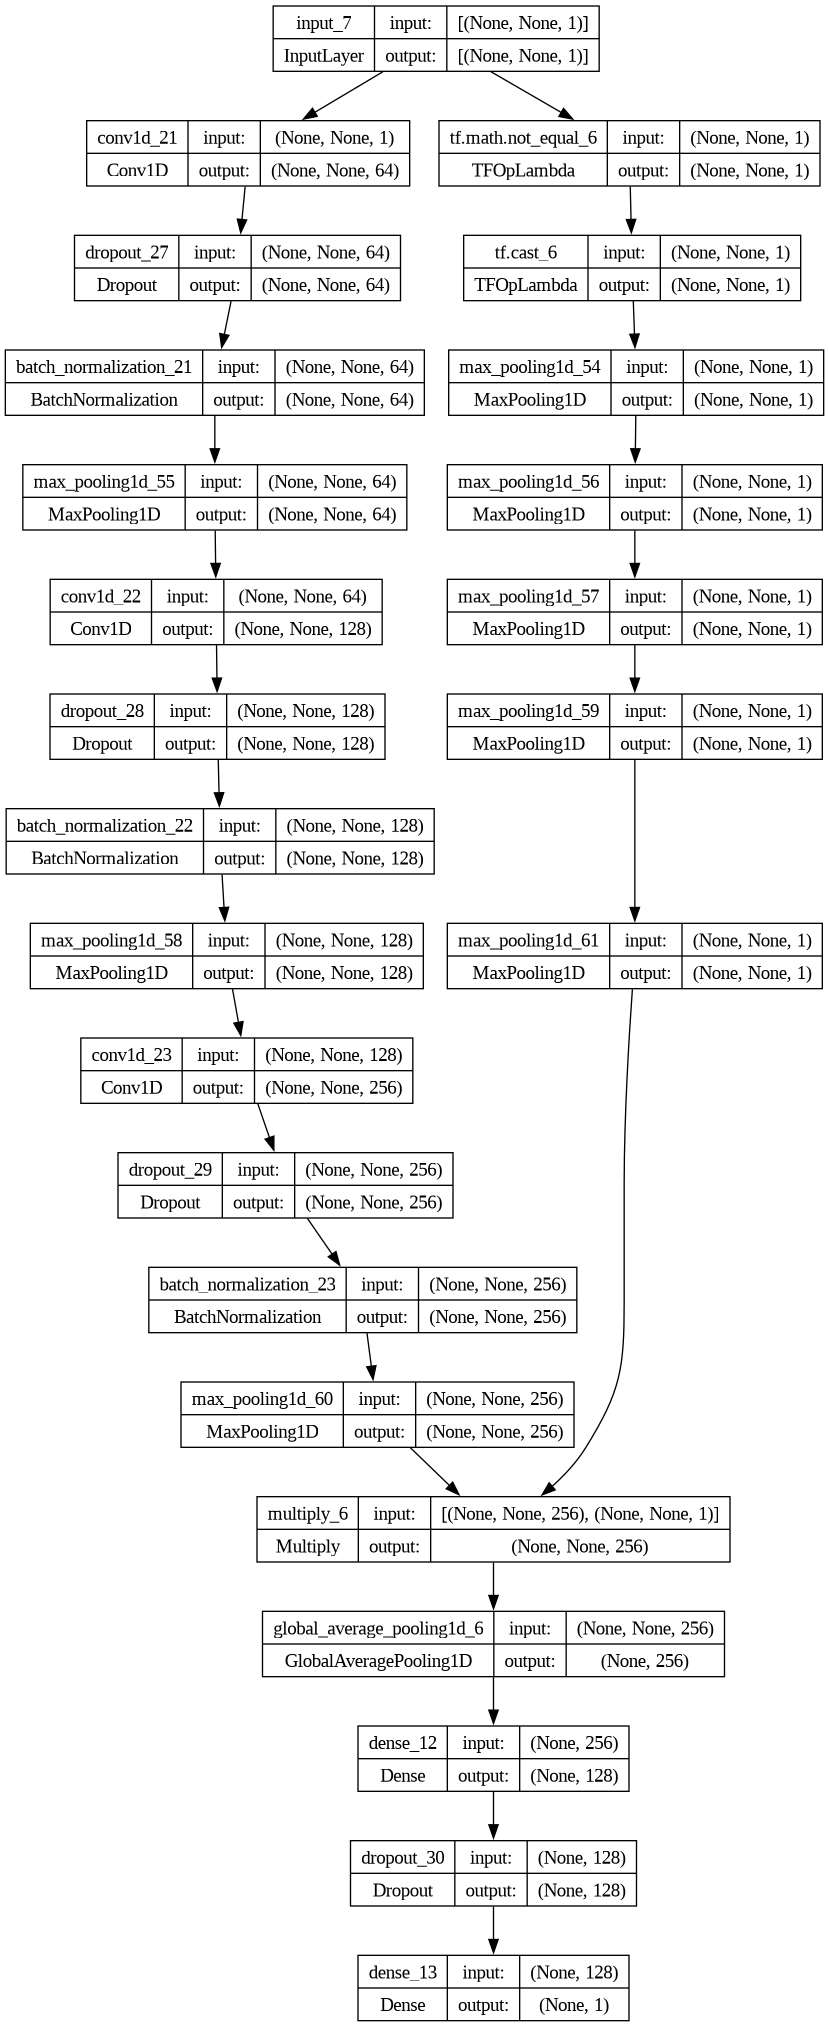

In [410]:
dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file,  show_shapes=True)

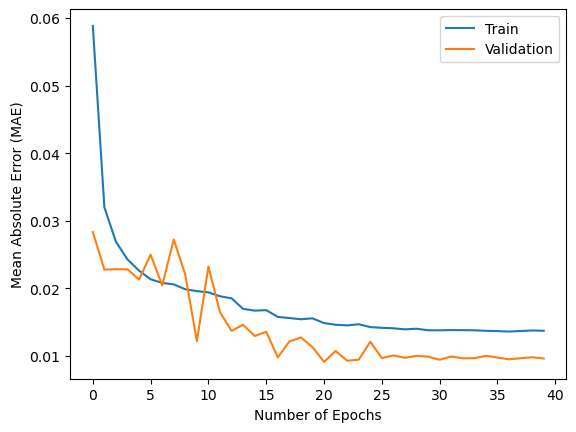

In [6]:
import matplotlib.pyplot as plt
plt.plot(hist['mae'], label = 'Train')
plt.plot(hist['val_mae'], label = 'Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()

In [8]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


NameError: name 'model' is not defined

In [9]:
plt.scatter(y_pred, y_test, color = 'red', label = 'predictions')
plt.plot(y_test, y_test, label = 'real values')
plt.legend()

NameError: name 'y_pred' is not defined

# Saliency Maps

#### definitions for saliency maps

In [416]:
#find the error diff for each prediction and its real values
errors = np.abs(y_pred.flatten() - y_test.flatten())

#find the 5 lowest error diff, and assign its signal, label, p peak and prediction
top5_idx = np.argsort(errors)[:5]
samples = np.stack([X_test[i] for i in top5_idx])
labels = np.stack([y_test[i] for i in top5_idx])
peaks = np.stack([beats_ppks_test[i] for i in top5_idx])
preds = np.stack([y_pred[i] for i in top5_idx])
# this variable is done so we can cut out the padding when plotting
xlim_length = [raw_lengths_test[i] for i in top5_idx]

#same thing but this time for the 5 worst predictions
bottom5_idx = np.argsort(-errors)[:5]
samples_bottom = np.stack([X_test[i] for i in bottom5_idx])
labels_bottom = np.stack([y_test[i] for i in bottom5_idx])
peaks_bottom = np.stack([beats_ppks_test[i] for i in bottom5_idx])
preds_bottom = np.stack([y_pred[i] for i in bottom5_idx])
xlim_length_bottom = [raw_lengths_test[i] for i in bottom5_idx]


#each saliency map needs a score values
def score(inputs):
    return model(inputs)

# def score(output):
#     return output[:, 0]  


#### Vanilla saliency

/tmp/ipykernel_206/543413360.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


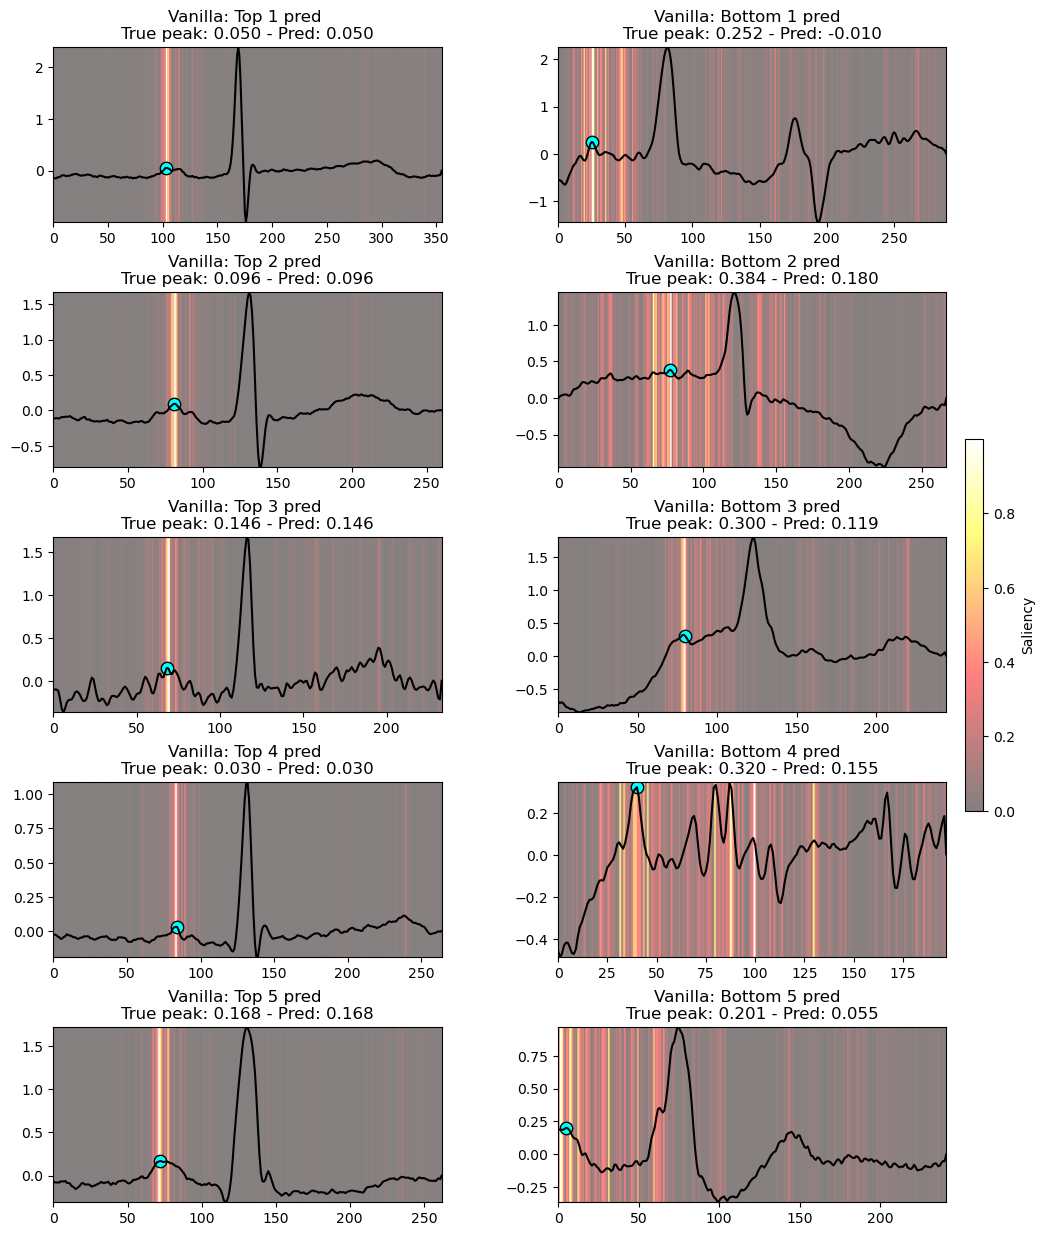

In [417]:
#create vanilla saliency instance
van_saliency = Saliency(model, model_modifier=None, clone=True)

#create subplots to format the plots side by side
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#------------TOP 5----------------
vanilla_saliency_map = van_saliency(score, samples)
for i in range(len(samples)):
    ax = axes[i, 0] # plots on left side
    im = ax.imshow(
    np.vstack([vanilla_saliency_map[i], vanilla_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower') # creates a heatmap style over lay
    ax.plot(samples[i, :, 0], color='black', label='ECG') # plot the signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') # Mark the P peak
    ax.set_title(f"Vanilla: Top {i+1} pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}") # title each plot 
    ax.set_xlim(0, xlim_length[i]) #cut off plot when padding starts

#---------------BOTTOM 5-----------------------
#Same as before but the variables have been changed for the bottom 5 predictions
vanilla_saliency_map_bottom = van_saliency(score, samples_bottom)
for i in range(len(samples_bottom)):
    ax = axes[i, 1] #plots on the right side
    im = ax.imshow(
    np.vstack([vanilla_saliency_map_bottom[i], vanilla_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Vanilla: Bottom {i+1} pred  \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])
  
#plot one colour bar that represents all
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### SmoothGrad

/tmp/ipykernel_206/2708602798.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


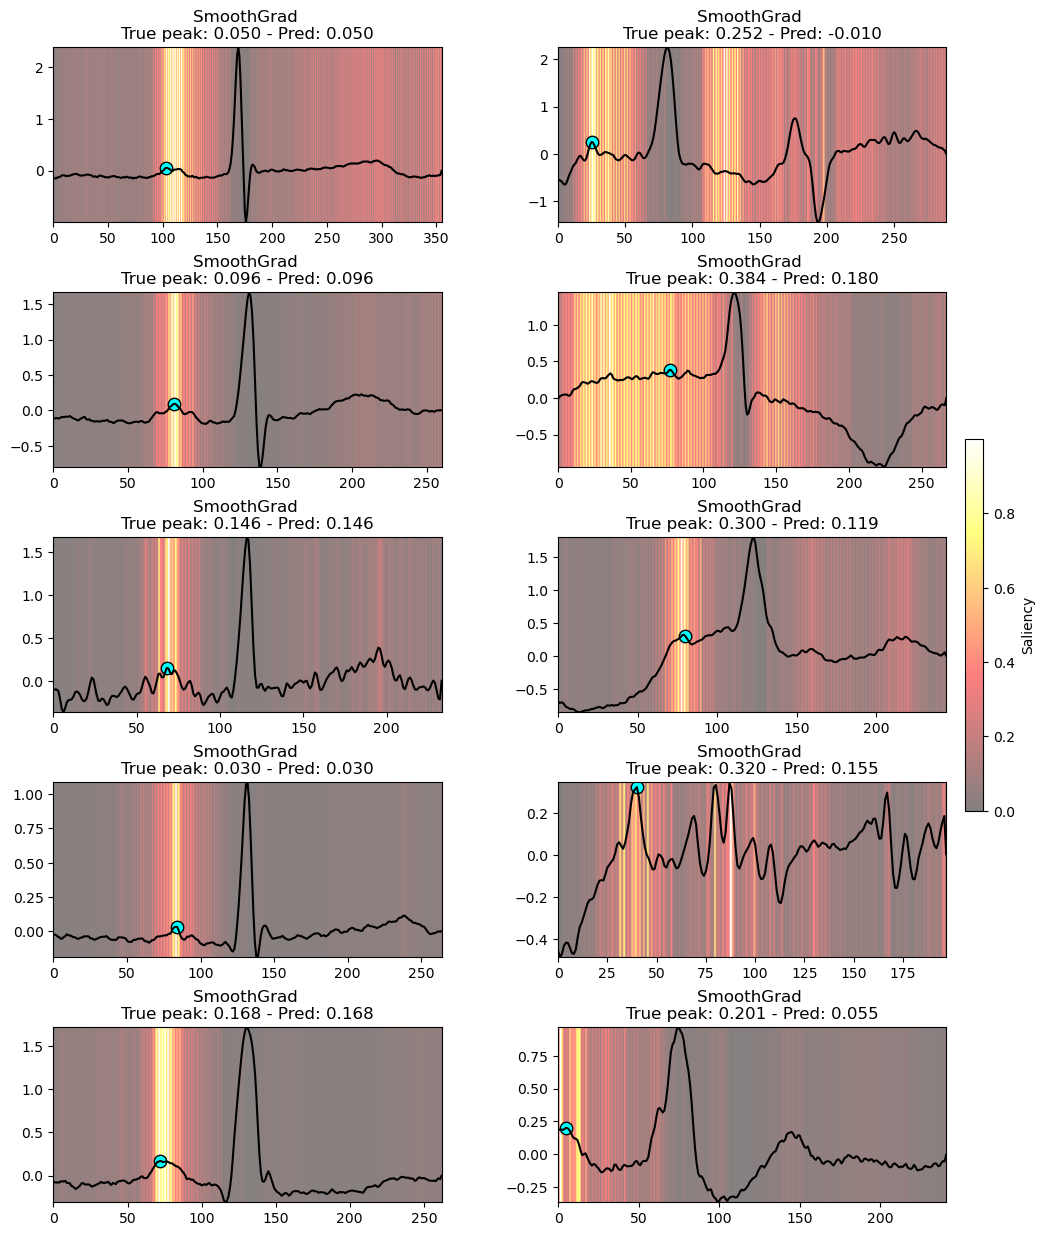

In [418]:
# Create smooth grad saliency instance
sg_saliency = Saliency(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)


#-------------TOP 5--------------------------
sg_saliency_map = sg_saliency(score,samples,smooth_samples=500,  smooth_noise=0.05)  #generate saliency map with the parameters

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_np = (samples != 0).astype(np.float32)  
mask_np = np.squeeze(mask_np, axis=-1)    
sg_saliency_map[mask_np == 0] = 0

for i in range(len(samples)):
    ax = axes[i, 0] #plot on left side
    im = ax.imshow(
    np.vstack([sg_saliency_map[i], sg_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower') #plots saliency like a heatmap
    ax.plot(samples[i, :, 0], color='black', label='ECG') #plots ECG signal
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') #marks P peak
    ax.set_title(f"SmoothGrad \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i]) #cuts off at padding

#-------------------------BOTTOM 5-----------------------------------------

sg_saliency_map_bottom = sg_saliency(score, samples_bottom, smooth_samples=500, smooth_noise=0.05) # keep the parameters the same

mask_np = (samples_bottom != 0).astype(np.float32)  
mask_np = np.squeeze(mask_np, axis=-1)    
sg_saliency_map_bottom[mask_np == 0] = 0

for i in range(len(samples_bottom)):
    ax = axes[i, 1] #prints on right side
    im = ax.imshow(
    np.vstack([sg_saliency_map_bottom[i], sg_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower')
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"SmoothGrad \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### GradCAM

/tmp/ipykernel_206/1979281388.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_206/1979281388.py:69: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


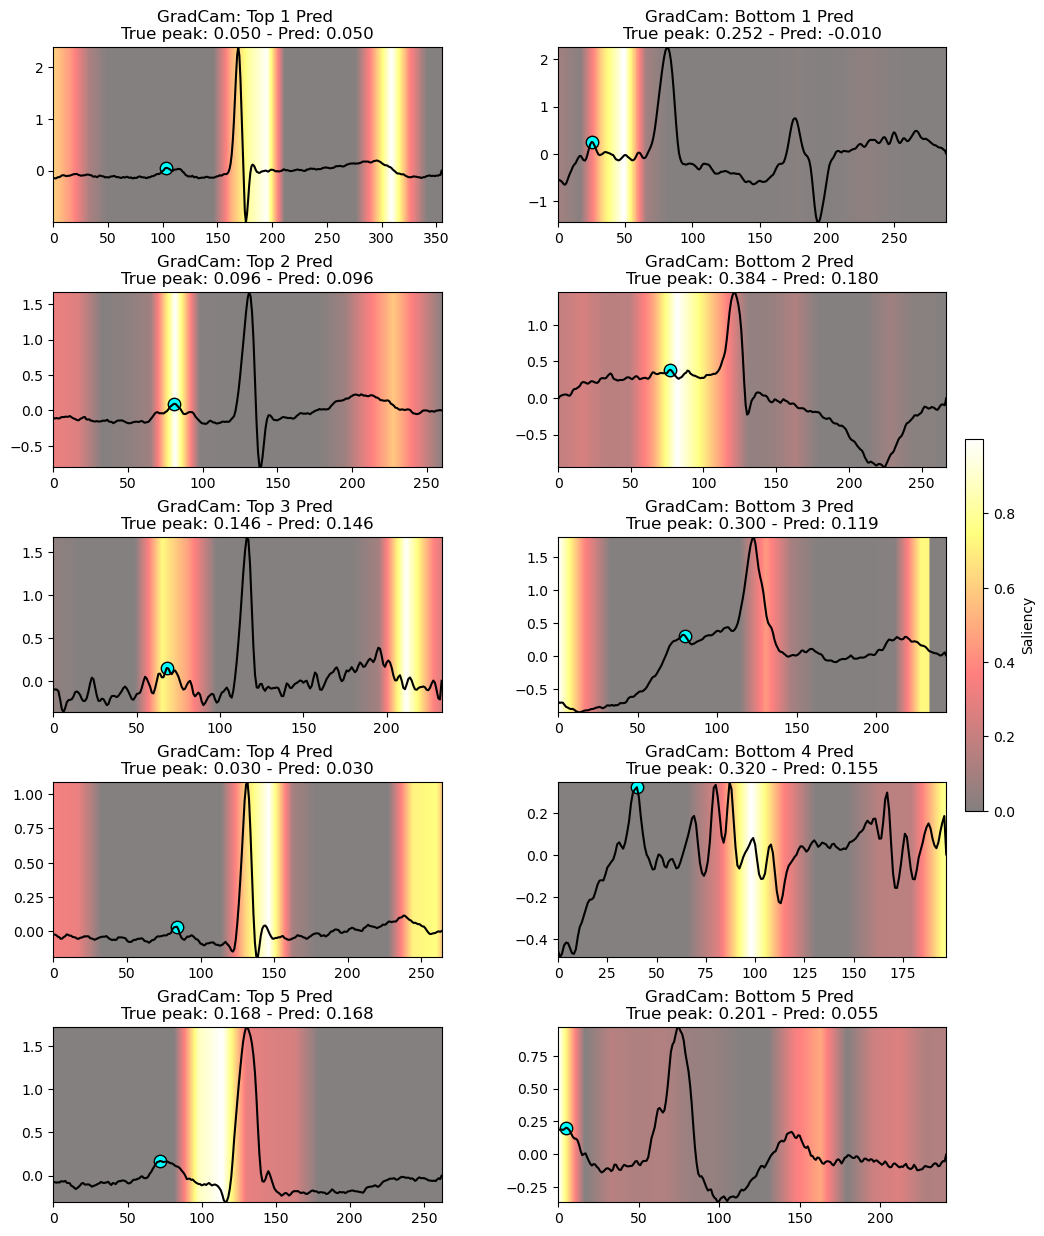

In [422]:
# Get the penultimate Conv1D layer (can use index or layer name)
penultimate_layer = 'conv1d_23'

# Create GradCAM object
gradcam = Gradcam(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------------TOP 5--------------------------------------
# Generate cam
cam_grad = gradcam(score, samples, penultimate_layer=penultimate_layer)

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_cam_grad = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_grad = np.squeeze(mask_cam_grad, axis=-1)       # Remove channel dimension if present

cam_grad[mask_cam_grad == 0] = 0

cam_resized_grad = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_grad
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
    np.vstack([cam_resized_grad[i], cam_resized_grad[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"GradCam: Top {i+1} Pred \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])


#-----------------------BOTTOM 5--------------------------------------

cam_grad_bottom = gradcam(score, samples_bottom, penultimate_layer=penultimate_layer)

# Any features on padding that might come up as salient has been reduced to 0. (Possibly not needed anymore as plot cuts at padding now)
mask_cam_grad_bottom = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_grad_bottom = np.squeeze(mask_cam_grad_bottom, axis=-1)       # Remove channel dimension if present
cam_grad_bottom[mask_cam_grad_bottom == 0] = 0

cam_grad_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_grad_bottom
])

for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    ax.imshow(
    np.vstack([cam_grad_resized_bottom[i], cam_grad_resized_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"GradCam: Bottom {i+1} Pred \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### GradCAM++

/tmp/ipykernel_206/915935850.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_206/915935850.py:68: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


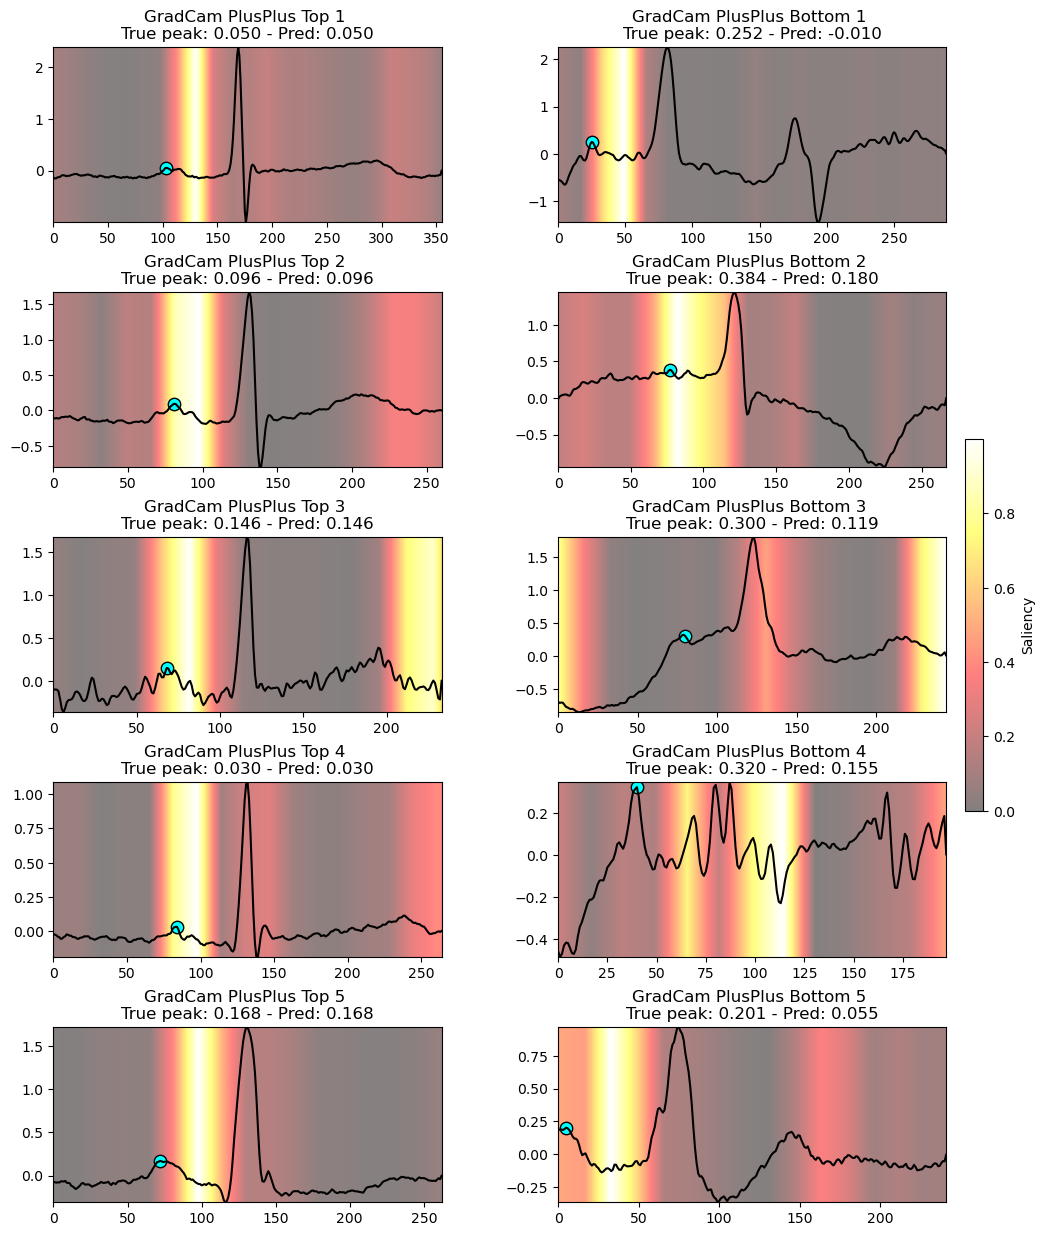

In [423]:
# Create GradCAM++ object
gradcam_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------TOP 5--------------------------

# Generate heatmap with GradCAM++
cam_plus = gradcam_plus(score, samples, penultimate_layer =  penultimate_layer)


mask_cam_plus = (samples != 0).astype(np.float32) 
mask_cam_plus = np.squeeze(mask_cam_plus, axis=-1)
cam_plus[mask_cam_plus == 0] = 0

cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
    np.vstack([cam_plus_resized[i], cam_plus_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_title(f"GradCam PlusPlus Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])

#-----------------------------BOTTOM 5-------------------------------

# Generate heatmap with GradCAM++
cam_plus_bottom = gradcam_plus(score, samples_bottom, penultimate_layer =  penultimate_layer)

# After computing sg_saliency_map
mask_cam_plus_bottom = (samples_bottom != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_plus_bottom = np.squeeze(mask_cam_plus_bottom, axis=-1)       # Remove channel dimension if present
cam_plus_bottom[mask_cam_plus_bottom == 0] = 0

cam_plus_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_plus_bottom
])


for i in range(len(samples)):
    ax = axes[i, 1]
    ax.imshow(
    np.vstack([cam_plus_resized_bottom[i], cam_plus_resized_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    ax.set_title(f"GradCam PlusPlus Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### ScoreCAM

40/40 [==============================] - 0s 1ms/step


/tmp/ipykernel_206/4215900287.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_206/4215900287.py:54: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


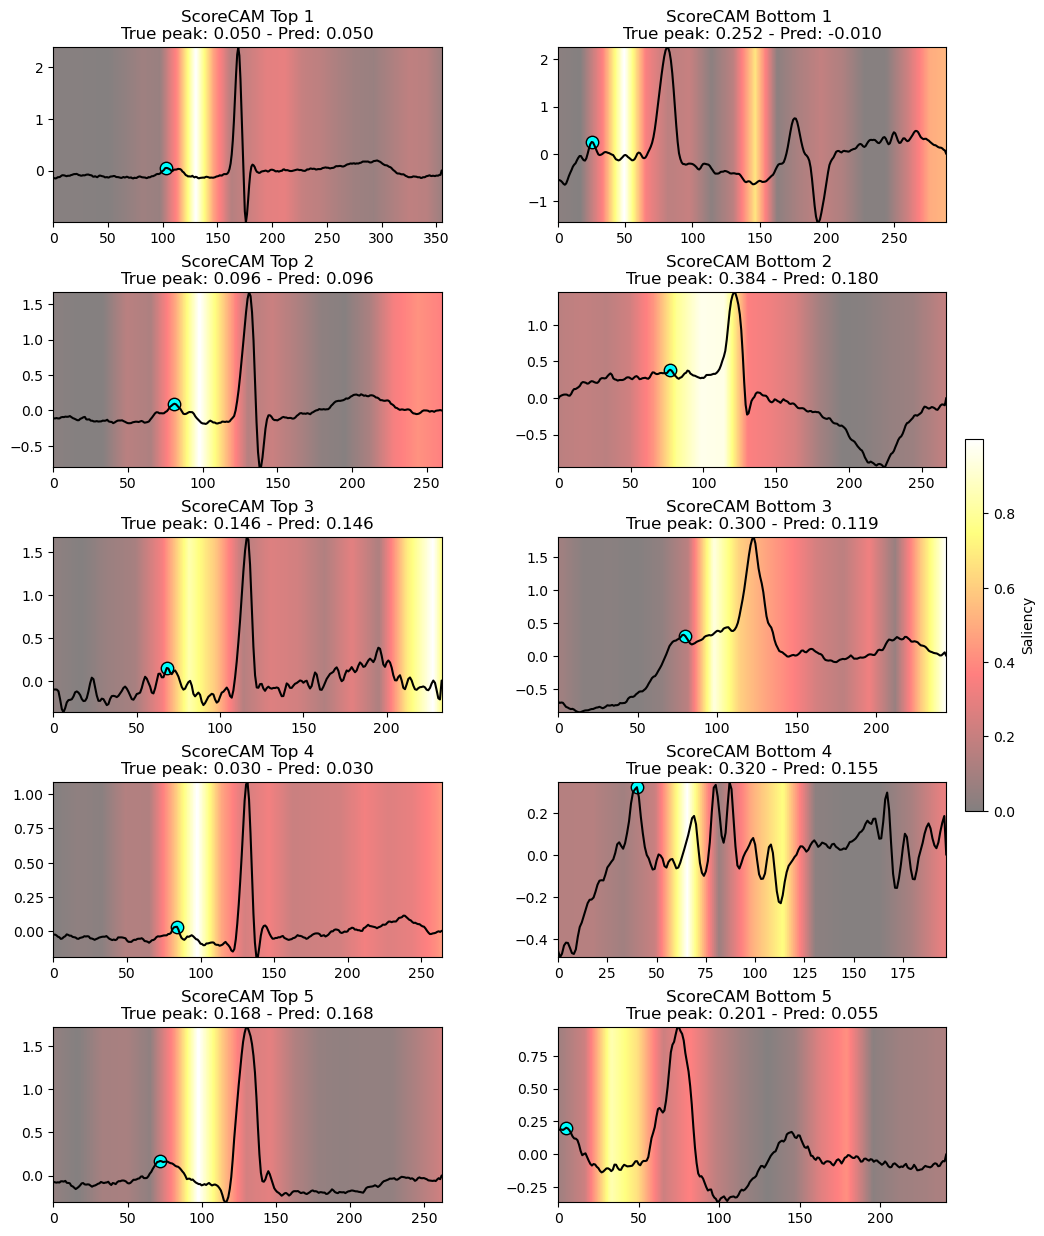

In [424]:
# Create ScoreCAM object
scorecam = Scorecam(model)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-------------------------------TOP 5-----------------------
# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    ax = axes[i, 0]
    ax.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])


#-----------------------BOTTOM 5-------------------
cam_bottom = scorecam(score, samples_bottom, penultimate_layer= penultimate_layer)

cam_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_bottom
])


for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    ax.imshow(
        np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### Faster ScoreCAM

1/4 [======>.......................] - ETA: 0s

/tmp/ipykernel_206/250961738.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


4/4 [==============================] - 0s 57ms/step


/tmp/ipykernel_206/250961738.py:56: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 11 Axes> than <Figure size 1200x1500 with 11 Axes> which fig.colorbar is called on.


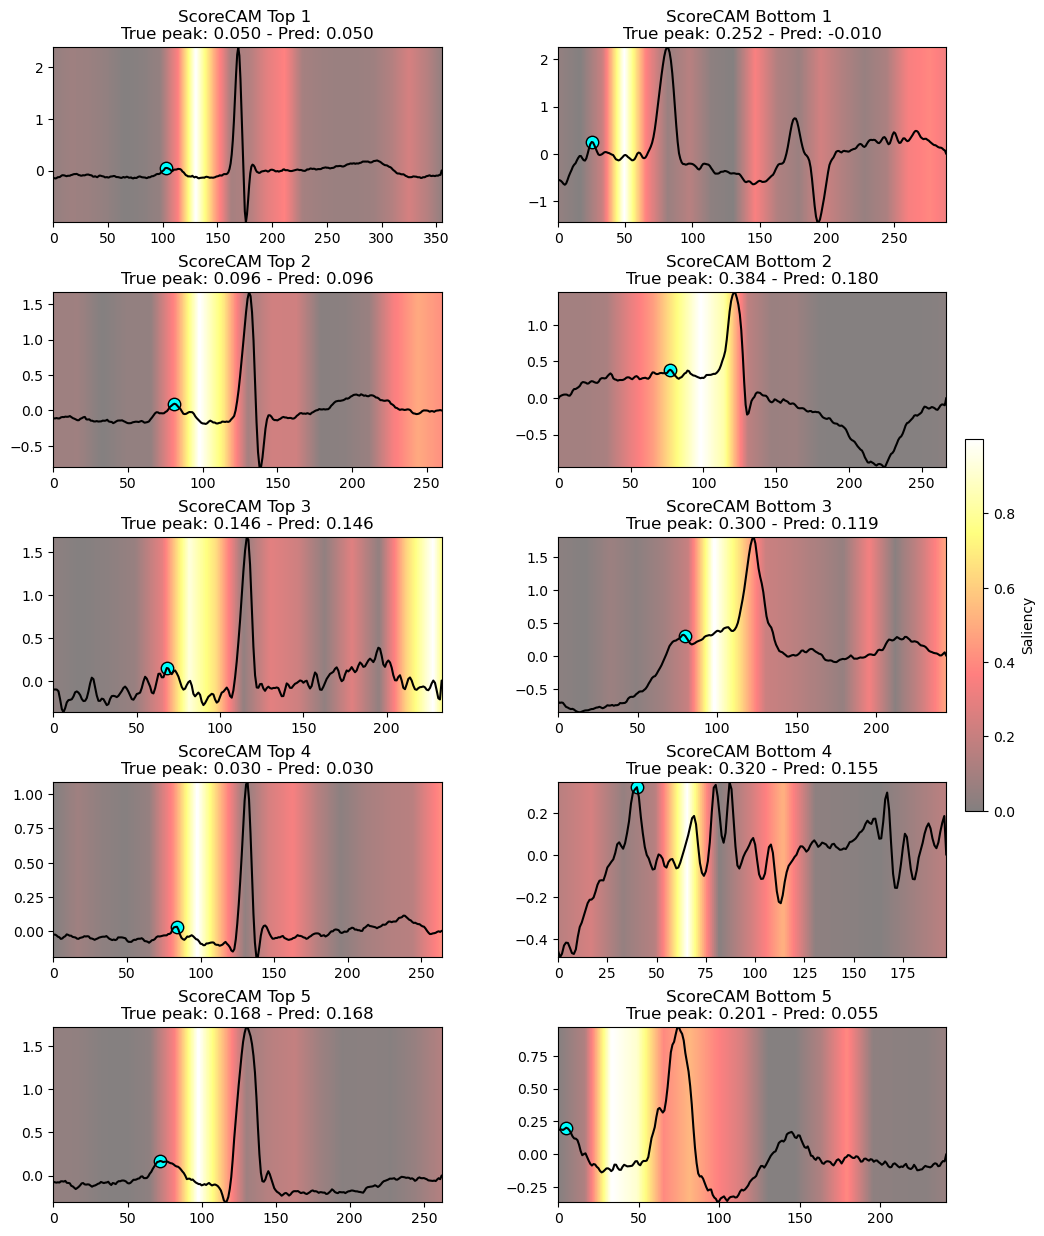

In [425]:
# Create ScoreCAM object
scorecam = Scorecam(model)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)


#---------------------TOP 5-----------------------
cam = scorecam(score, samples, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])


for i in range(len(samples)):
    ax = axes[i,0]
    ax.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0,xlim_length[i])

#----------------------BOTTOM 5-----------------------------

# Generate heatmap with ScoreCAM
cam_bottom = scorecam(score, samples_bottom, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized_bottom = np.array([
    scipy.ndimage.zoom(c, samples_bottom.shape[1] / c.shape[0], order=1)
    for c in cam_bottom
])

for i in range(len(samples_bottom)):
    ax = axes[i,1]
    ax.imshow(
        np.vstack([cam_resized_bottom[i], cam_resized_bottom[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
        origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"ScoreCAM Bottom {i+1} \nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0,xlim_length_bottom[i])


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### Guided BackPropagation

/tmp/ipykernel_206/3268863775.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


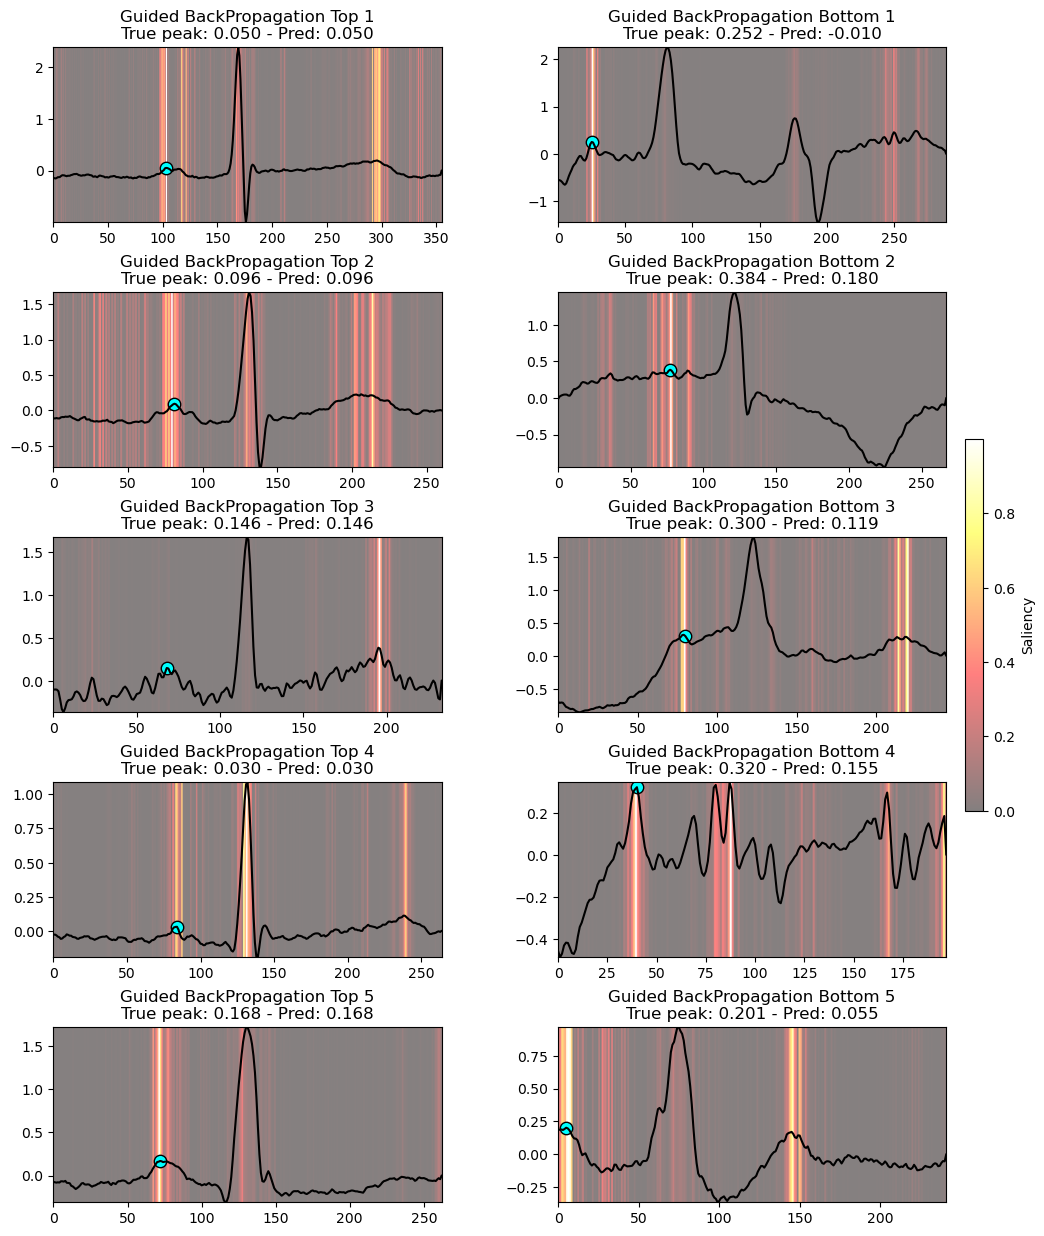

In [426]:
gb_saliency = Saliency(model, model_modifier=GuidedBackpropagation(), clone=True)

fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-------------------TOP 5--------------------------

gb_saliency_map = gb_saliency(score, samples)

for i in range(len(samples)):
    ax = axes[i, 0]
    im = ax.imshow(
    np.vstack([gb_saliency_map[i], gb_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Guided BackPropagation Top {i+1}\nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0,xlim_length[i])

#-----------------------BOTTOM 5-------------------------
gb_saliency_map_bottom = gb_saliency(score, samples_bottom)

for i in range(len(samples_bottom)):
    ax = axes[i, 1]
    im = ax.imshow(
    np.vstack([gb_saliency_map_bottom[i], gb_saliency_map_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    ax.set_title(f"Guided BackPropagation Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0,xlim_length_bottom[i])
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Saliency")

#### Guided GradCAM

/tmp/ipykernel_206/25277134.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


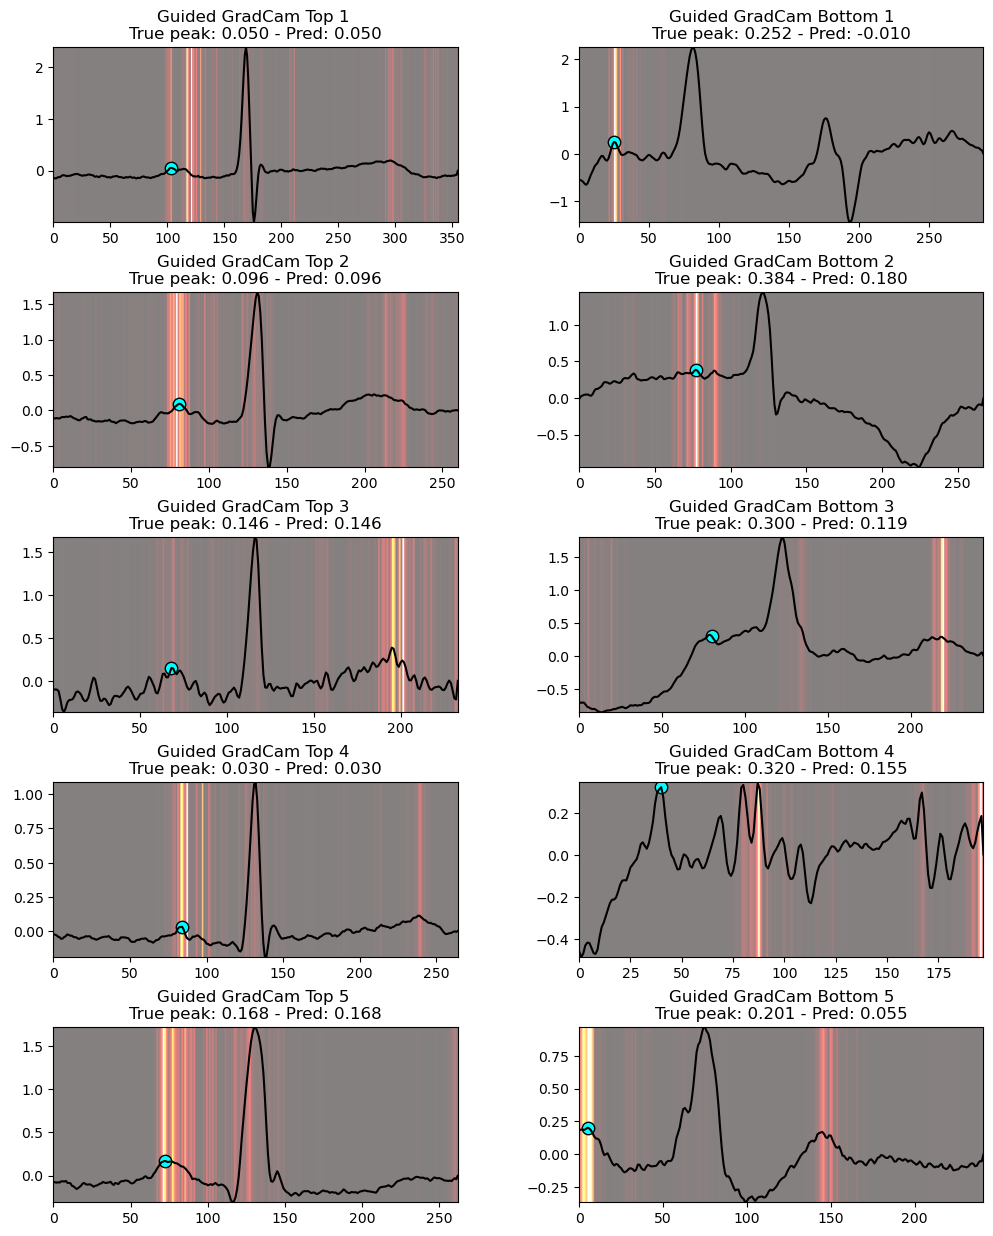

In [427]:
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(12, 15),
    gridspec_kw={"wspace": 0.3, "hspace": 0.4}
)

#-----------------------TOP 5------------------------

guided_gradcam = gb_saliency_map * cam_resized
for i in range(len(samples)):
    ax = axes[i,0]
    ax.imshow(
    np.vstack([guided_gradcam[i], guided_gradcam[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') 
    ax.set_title(f"Guided GradCam Top {i+1} \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    ax.set_xlim(0, xlim_length[i])
    
#-----------------BOTTOM 5-------------------------

guided_gradcam_bottom = gb_saliency_map_bottom * cam_grad_resized_bottom
for i in range(len(samples_bottom)):
    ax = axes[i,1]
    ax.imshow(
    np.vstack([guided_gradcam_bottom[i], guided_gradcam_bottom[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples_bottom.shape[1], samples_bottom[i, :, 0].min(), samples_bottom[i, :, 0].max()],
    origin='lower'
    )
    ax.plot(samples_bottom[i, :, 0], color='black', label='ECG')
    ax.scatter( peaks_bottom[i] , samples_bottom[i][peaks_bottom[i]], c='cyan', edgecolors='k', s=80, label='P-Peak') 
    ax.set_title(f"Guided GradCam Bottom {i+1}\nTrue peak: {float(labels_bottom[i]):.3f} - Pred: {float(preds_bottom[i]):.3f}")
    ax.set_xlim(0, xlim_length_bottom[i])

#### Average saliency map

In [428]:
#find index of top 100 predictions
top100_idx = np.argsort(errors)[:100]
#gather the signals
signals_top100 = X_test[top100_idx] 
#find their r peaks
r_peaks = [beats_rpks_test[i] for i in top100_idx]

#get saliency for each technqiue on the top 100
vanilla_saliency_map_avg = van_saliency(score, signals_top100)
sg_saliency_map_avg = sg_saliency(score, signals_top100, smooth_samples=20, smooth_noise=0.20) 
cam_grad_avg = gradcam(score, signals_top100, penultimate_layer=penultimate_layer)
cam_plus_avg = gradcam_plus(score, signals_top100, penultimate_layer =  penultimate_layer)
cam_score_avg = scorecam(score, signals_top100, penultimate_layer= penultimate_layer)
cam_fastscore_avg = scorecam(score, signals_top100, penultimate_layer= penultimate_layer,  max_N=10)
gb_saliency_map_avg = gb_saliency(score, signals_top100)
guided_gradcam_avg = gb_saliency_map_avg * cam_grad_avg

all_avg_saliency = [vanilla_saliency_map_avg, sg_saliency_map_avg, cam_grad_avg, cam_plus_avg, cam_score_avg, cam_fastscore_avg, gb_saliency_map_avg, guided_gradcam_avg]
title_sal = ['Vanilla', 'SmoothGrad', 'GradCam', 'GradCamPlus', 'ScoreCam', 'Faster ScoreCam', 'Guided BackPropagation', 'Guided GradCam']

235/235 [==============================] - 0s 2ms/step


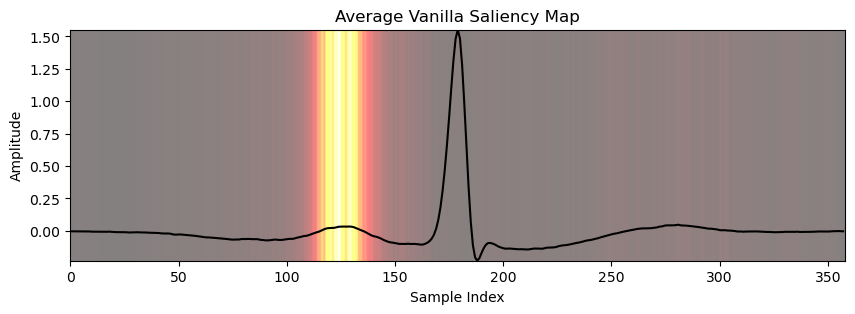

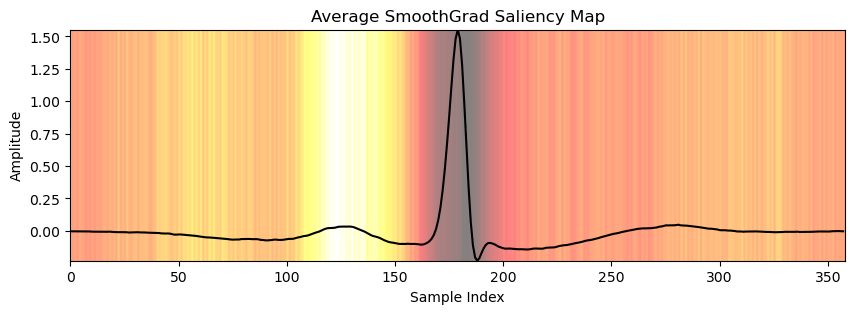

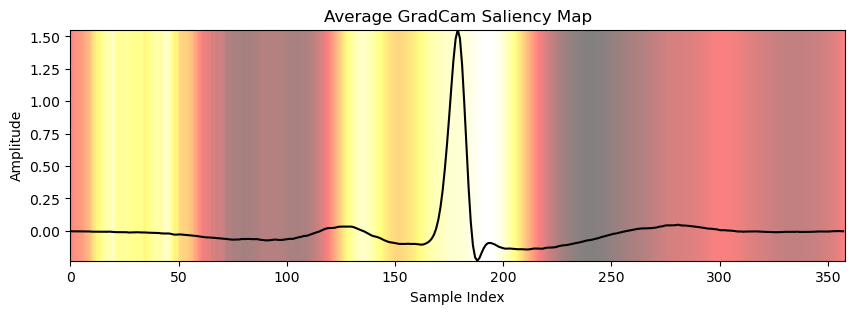

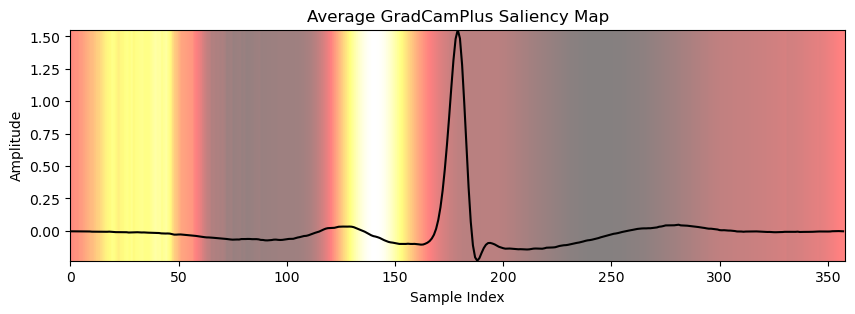

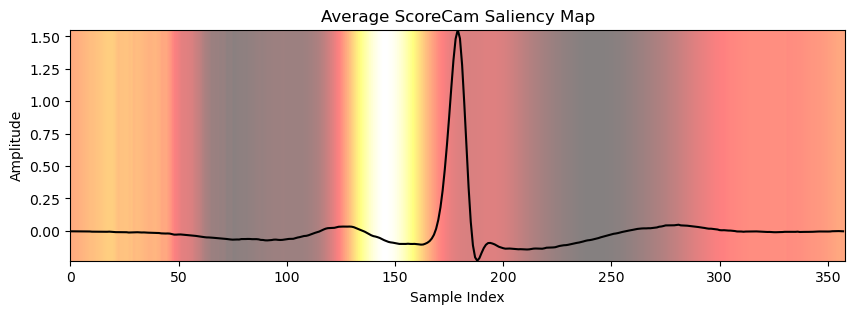

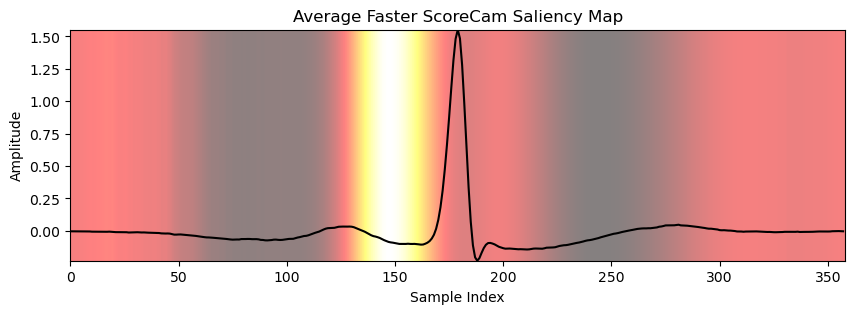

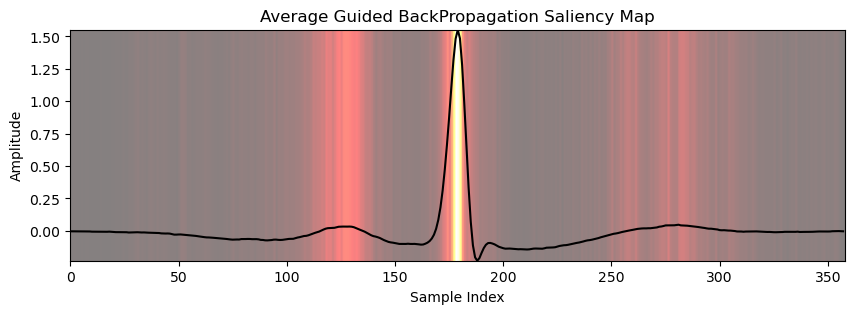

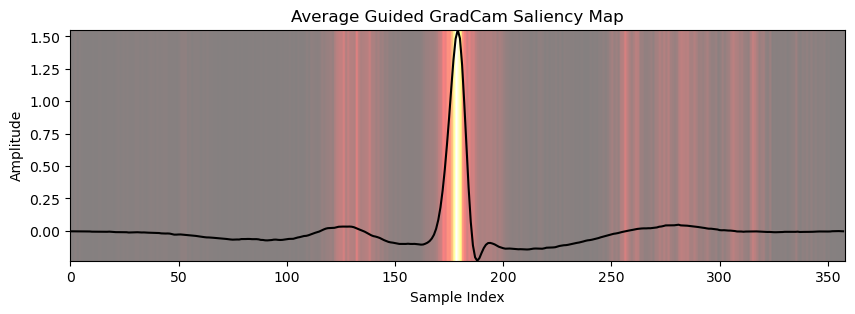

In [440]:
#find the center of the signal, where all R peaks will be aligned
center = signals_top100.shape[1] // 2
# create a new array of shape (100, 778) filled with zeros, to hold the shifted beats.
aligned = np.zeros_like(signals_top100)

# shift each beat so its R-peak lands at center
for n, (sig, r_loc) in enumerate(zip(signals_top100, r_peaks)):
    shift = center - r_loc
    aligned[n] = np.roll(sig, shift)

#compute avg ecg
avg_aligned = np.mean(aligned, axis=0)

for i, sal in enumerate(all_avg_saliency):
    aligned_sal = np.zeros_like(sal)
    
    for n, r_loc in enumerate(r_peaks):
        shift = center - r_loc
        aligned_sal[n] = np.roll(sal[n], shift)
    
    avg_saliency = aligned_sal.mean(axis=0)

    # plt.figure(figsize=(10, 3))
    # plt.plot(avg_aligned)
    # plt.plot(avg_saliency)
    # plt.title(f"Average {title_sal[i]} Saliency Map")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    # plt.tight_layout()
    # plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 3))

    ax.imshow(
        np.vstack([avg_saliency, avg_saliency]), cmap='hot', aspect='auto',alpha=0.5,
        extent=[0, len(avg_aligned), avg_aligned.min(), avg_aligned.max()], origin='lower')
    
    ax.plot(avg_aligned, color = 'black')
    ax.set_title(f"Average {title_sal[i]} Saliency Map")
    ax.set_xlim(0, len(avg_aligned))
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    plt.show()

# Activation Maximization

#### Last Conv Layer

200/200 [==============================] - 5s 18ms/step - Score: 7693.8848 - Norm: 609.2776


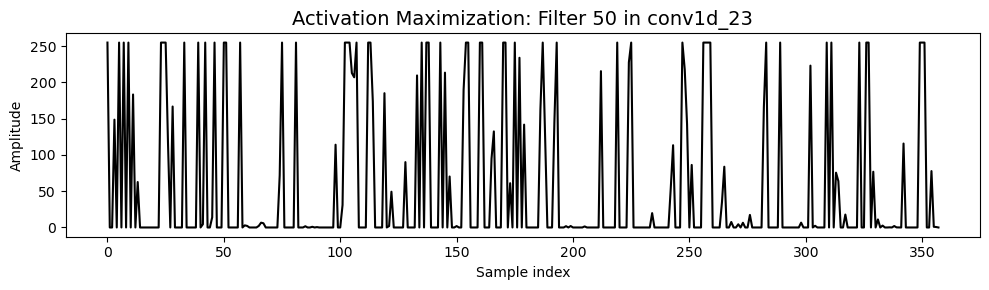

200/200 [==============================] - 4s 18ms/step - Score: -26.3870 - Norm: 12.6758


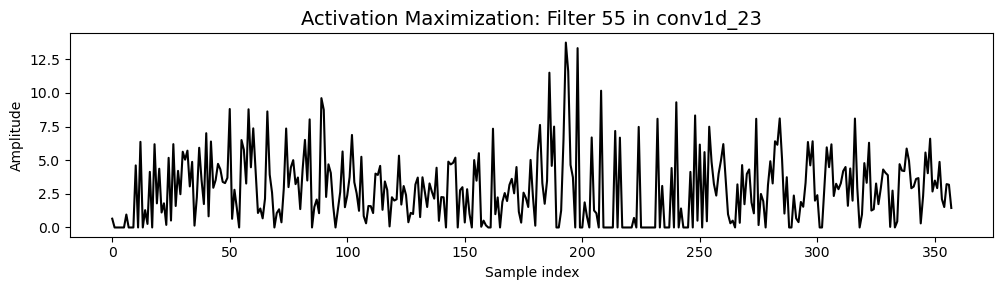

200/200 [==============================] - 4s 18ms/step - Score: 3306.0728 - Norm: 511.7310


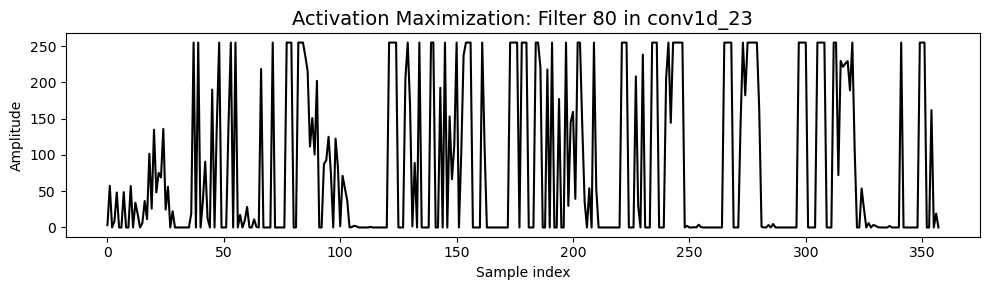

200/200 [==============================] - 4s 18ms/step - Score: 744.1453 - Norm: 167.3755


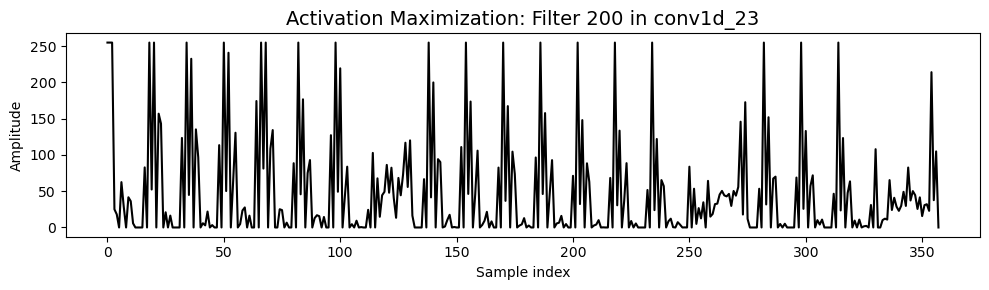

200/200 [==============================] - 4s 18ms/step - Score: -11.0316 - Norm: 15.7570


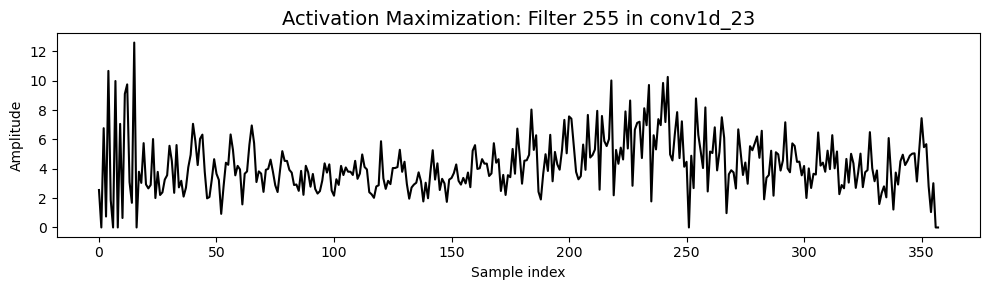

In [431]:
layer_name = 'conv1d_23' #target layer

#new model whose output is replaced to `block5_conv3` layer's output
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
#modify the model's last activation function to linear
replace2linear = ReplaceToLinear()

activation_maximization = ActivationMaximization(
    model,
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

filter_numbers = [50,55,80,200,255]
nrows = 1
ncols = len(filter_numbers)


for idx, i in enumerate(filter_numbers):
    def score_am(output):
        return tf.reduce_mean(output[:, :, i])

    # Generate maximized activation
    activations = activation_maximization(score_am, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
    activations = activations.numpy()

    plt.figure(figsize=(10, 3))
    plt.plot(activations[0].squeeze(), color='black')
    plt.title(f'Activation Maximization: Filter {i} in {layer_name}', fontsize=14)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

#### Dense layer

200/200 [==============================] - 6s 27ms/step - Score: 21334.0996 - Norm: 667.7866


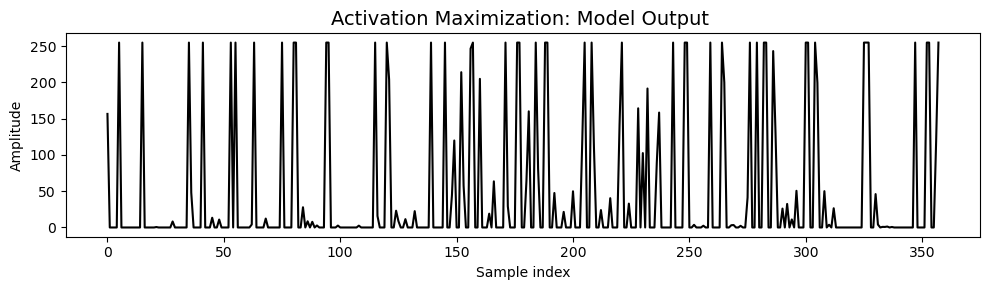

In [432]:
def score_dense(output):
    return output[:, 0]
    
activation_maximization = ActivationMaximization(model, model_modifier = None, clone=True)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

# Generate maximized activation
activations = activation_maximization(score_dense, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
activations = activations.numpy()

plt.figure(figsize=(10, 3))
plt.plot(activations[0].squeeze(), color='black')
plt.title(f'Activation Maximization: Model Output ', fontsize=14)
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()